STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.0



# ResNet-34 on Cifar-10

## Imports

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# From local helper files
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 20
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [7]:
##########################
### CIFAR-10 DATASET
##########################


# train_transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((120, 120)),
#     torchvision.transforms.RandomCrop((110, 110)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#                                       ])

# test_transforms = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((120, 120)),        
#     torchvision.transforms.CenterCrop((110, 110)),            
#     torchvision.transforms.ToTensor(),                
#     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
#     batch_size=BATCH_SIZE,
#     validation_fraction=0.1,
#     train_transforms=train_transforms,
#     test_transforms=test_transforms,
#     num_workers=2)

# # Checking the dataset
# for images, labels in train_loader:  
#     print('Image batch dimensions:', images.shape)
#     print('Image label dimensions:', labels.shape)
#     print('Class labels of 10 examples:', labels[:10])
#     break
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([7, 5, 5, 5, 0, 1, 4, 3, 6, 7])


## Model

In [8]:
# Code taken & adjusted from: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return torch.nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(torch.nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out
        


class Bottleneck(torch.nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion=4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 groups=1, base_width=64, dilation=1, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)


        return out

class ResNet(torch.nn.Module):

    def __init__(self, block, layers, num_classes, zero_init_residual=False, groups=1,
                 width_per_group=64, replace_stride_with_dilation=None, norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = torch.nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = torch.nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                                     bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (torch.nn.BatchNorm2d, torch.nn.GroupNorm)):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    torch.nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    torch.nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks,
                    stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

 

        return x

In [9]:
def cyclical_learning_rate(batch_step,
                           step_size,
                           base_lr=0.01,
                           max_lr=0.1,
                           mode='triangular',
                           gamma=0.999995):

    cycle = np.floor(1 + batch_step / (2. * step_size))
    x = np.abs(batch_step / float(step_size) - 2 * cycle + 1)

    lr_delta = (max_lr - base_lr) * np.maximum(0, (1 - x))
    
    if mode == 'triangular':
        pass
    elif mode == 'triangular2':
        lr_delta = lr_delta * 1 / (2. ** (cycle - 1))
    elif mode == 'exp_range':
        lr_delta = lr_delta * (gamma**(batch_step))
    else:
        raise ValueError('mode must be "triangular", "triangular2", or "exp_range"')
        
    lr = base_lr + lr_delta
    
    return lr

In [10]:
def compute_accuracy(model, data_loader):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
        x = model(features)
        _, predicted_labels = torch.max(x, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


In [11]:
model = ResNet(BasicBlock, layers=[3, 4, 6, 3], num_classes=10) # ResNet34

model = model.to(DEVICE)
#################################
### Setting for this run
#################################

num_epochs = 20
iter_per_ep = len(train_loader.sampler.indices) // train_loader.batch_size
base_lr = 0.01
max_lr = 0.1
batch_step=-1

#################################
### Init Model
#################################

torch.manual_seed(RANDOM_SEED)


##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(model.parameters(), lr=base_lr)  

########################################################################
# Collect the data to be evaluated via the LR Range Test
collect = {'epoch': [], 'cost': [], 'train_acc': [], 'val_acc': []}
########################################################################

start_time = time.time()
for epoch in range(num_epochs):
    epoch_avg_cost = 0.
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        x = model(features)
        cost = cost_fn(x, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        epoch_avg_cost += cost
        
        #############################################
        # Logging
        # if not batch_step % 20:
        #     print('Batch %5d/%d' % (batch_step, iter_per_ep*num_epochs),
        #                             end='')
        #     print('   Cost: %.5f' % cost)     

        if not batch_idx % 20:
              print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')  
    #############################################
    # Collect stats    
    model = model.eval()
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, valid_loader)
    epoch_avg_cost /= batch_idx+1
    collect['epoch'].append(epoch+1)
    collect['val_acc'].append(val_acc)
    collect['train_acc'].append(train_acc)
    collect['cost'].append(epoch_avg_cost / iter_per_ep)
    
    ################################################
    # Logging
    print('Epoch %3d' % (epoch+1), end='')
    print('  |  Train/Valid Acc: %.2f/%.2f' % (train_acc, val_acc))
    
    
    #############################################
    # update learning rate
    base_lr = cyclical_learning_rate(batch_step=batch_step,
                                     step_size=num_epochs*iter_per_ep,
                                     base_lr=base_lr,
                                     max_lr=max_lr)
    for g in optimizer.param_groups:
        g['lr'] = base_lr
    ############################################
    

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    print('base_lr: ', base_lr)
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
#                                                        factor=0.1,
#                                                        mode='max',
#                                                        verbose=True)

# minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
#     model=model,
#     num_epochs=NUM_EPOCHS,
#     train_loader=train_loader,
#     valid_loader=valid_loader,
#     test_loader=test_loader,
#     optimizer=optimizer,
#     device=DEVICE,
#     scheduler=scheduler,
#     scheduler_on='valid_acc',
#     logging_interval=100)

# plot_training_loss(minibatch_loss_list=minibatch_loss_list,
#                    num_epochs=NUM_EPOCHS,
#                    iter_per_epoch=len(train_loader),
#                    results_dir=None,
#                    averaging_iterations=200)
# plt.show()

# plot_accuracy(train_acc_list=train_acc_list,
#               valid_acc_list=valid_acc_list,
#               results_dir=None)
# plt.ylim([60, 100])
# plt.show()

Epoch: 001/020 | Batch 000/351 | Cost: 2.5421
Epoch: 001/020 | Batch 020/351 | Cost: 2.2322
Epoch: 001/020 | Batch 040/351 | Cost: 2.1121
Epoch: 001/020 | Batch 060/351 | Cost: 1.9973
Epoch: 001/020 | Batch 080/351 | Cost: 1.9387
Epoch: 001/020 | Batch 100/351 | Cost: 1.8275
Epoch: 001/020 | Batch 120/351 | Cost: 1.7729
Epoch: 001/020 | Batch 140/351 | Cost: 1.8703
Epoch: 001/020 | Batch 160/351 | Cost: 1.8673
Epoch: 001/020 | Batch 180/351 | Cost: 1.8216
Epoch: 001/020 | Batch 200/351 | Cost: 1.7066
Epoch: 001/020 | Batch 220/351 | Cost: 1.7546
Epoch: 001/020 | Batch 240/351 | Cost: 1.6339
Epoch: 001/020 | Batch 260/351 | Cost: 1.6150
Epoch: 001/020 | Batch 280/351 | Cost: 1.7780
Epoch: 001/020 | Batch 300/351 | Cost: 1.6166
Epoch: 001/020 | Batch 320/351 | Cost: 1.6680
Epoch: 001/020 | Batch 340/351 | Cost: 1.6279
Epoch   1  |  Train/Valid Acc: 40.47/40.10
Time elapsed: 1.71 min
base_lr:  0.010012820512820516
Total Training Time: 1.71 min
Epoch: 002/020 | Batch 000/351 | Cost: 1.4106

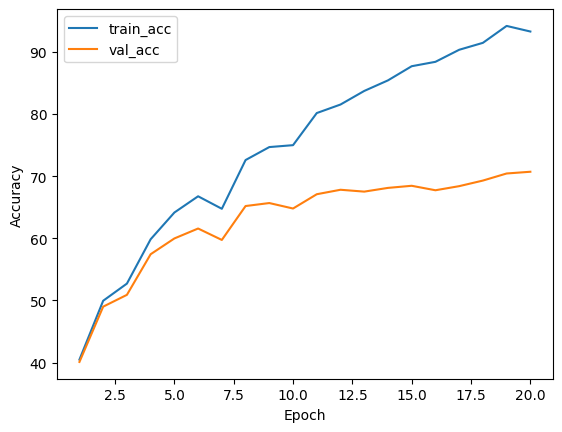

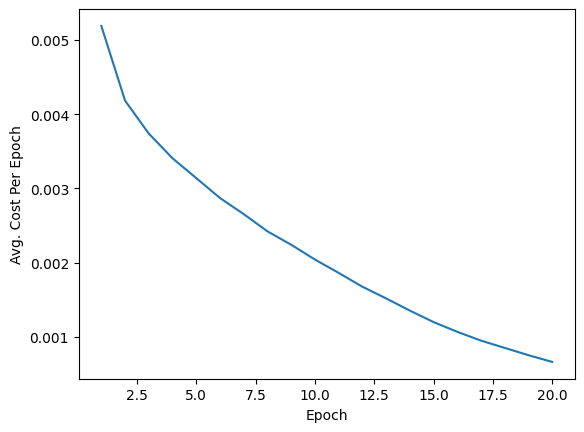

In [12]:
costarr=[collect['cost'][i].item() for i in range(len(collect['cost']))]
trainacc=[collect['train_acc'][i].item() for i in range(len(collect['train_acc']))]
validacc=[collect['val_acc'][i].item() for i in range(len(collect['val_acc']))]

plt.plot(collect['epoch'], trainacc, label='train_acc')
plt.plot(collect['epoch'], validacc, label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(collect['epoch'], costarr)
plt.xlabel('Epoch')
plt.ylabel('Avg. Cost Per Epoch')
plt.show()

In [13]:
print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 68.58%


In [ ]:
compute_accuracy(model, test_loader)

tensor(71.2000, device='cuda:0')

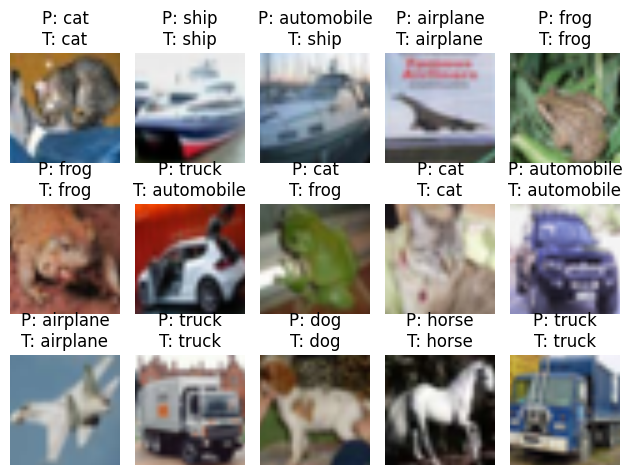

In [ ]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

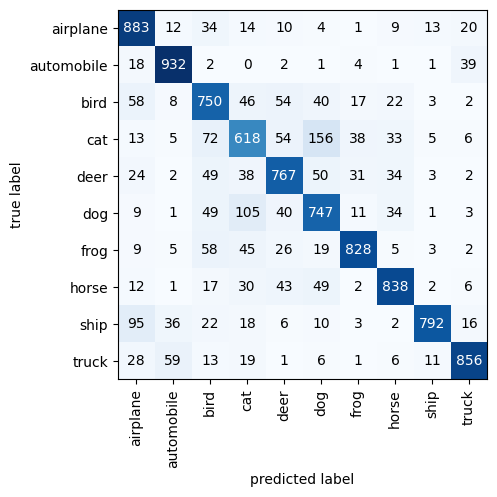

In [ ]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()